---
### Import as libs  
---

In [32]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
from carima import generate_matrices
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter, MaxNLocator
from matplotlib.animation import FuncAnimation, PillowWriter
import math as m
from simu import *
import cvxpy as cp

---
### Função para plotar, printar e tudo mais...
---

In [33]:
def plot(time, y_matriz, title="unknown", cols_name="unknown", time_aux=None, y_matriz_aux=None, plot=False, plot_no_cols=None):
    """
    Plota gráficos em grade (n_row x n_col) com estilo mais profissional,
    preservando 100% a lógica original de offsets, step/plot e legendas.
    """
    n_row, n_col = len(y_matriz), len(y_matriz[0])
    y_matriz = y_matriz[::-1]
    if y_matriz_aux is not None:
        y_matriz_aux = y_matriz_aux[::-1]

    # altura = 1 * n_row
    altura = n_row * 1.12

    with plt.rc_context({
        "font.size": 9,
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "figure.constrained_layout.use": False
    }):
        fig, axs = plt.subplots(n_row, n_col, figsize=(11, altura), sharex=True, constrained_layout=True)

        if n_row == 1 and n_col == 1:
            axs = [[axs]]
        elif n_row == 1:
            axs = [axs]
        elif n_col == 1:
            axs = [[ax] for ax in axs]

        for j in range(n_col):
            if cols_name != "unknown":
                axs[0][j].set_title(f'{title} - {cols_name[j]}')

        main_lw = 1.1
        aux_lw = 1.0
        msize = 3

        # encontra o valor de y máximo para ajustar todos os eixos 
        y_max, y_min = -np.inf, np.inf
        for i in range(n_row):
            for j in range(n_col):
                if plot_no_cols is not None and j in plot_no_cols:
                    continue
                dic = y_matriz[i][j]
                y_data = dic[0]
                y_max = max(y_max, np.max(y_data))
                y_min = min(y_min, np.min(y_data))
                if y_matriz_aux is not None:
                    dic_aux = y_matriz_aux[i][j]
                    y_data_aux = dic_aux[0]
                    y_max = max(y_max, np.max(y_data_aux))
                    y_min = min(y_min, np.min(y_data_aux))

        for i in range(n_row):
            for j in range(n_col):
                if plot_no_cols is not None and j in plot_no_cols:
                    axs[i][j].set_visible(False)
                    continue
                ax = axs[i][j]
                ax.set_axisbelow(True)  
                ax.grid(True, which='major', linestyle=':', alpha=0.5)
                ax.xaxis.set_minor_locator(AutoMinorLocator())
                ax.yaxis.set_minor_locator(AutoMinorLocator())
                ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
                ax.margins(y=0.1) 
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                ax.yaxis.set_major_locator(MaxNLocator(nbins='auto', prune=None))
                #ymin, ymax = ax.get_ylim()
                ax.set_ylim(y_min * 1.1, y_max * 1.1)

                for side in ["top", "right", "left", "bottom"]:
                    ax.spines[side].set_linewidth(0.8)
                    ax.spines[side].set_alpha(0.6)

                offset_x = 0
                if y_matriz_aux is not None and time_aux is not None:
                    dic_aux = y_matriz_aux[i][j]
                    offset_x = len(dic_aux[0])
                    if plot:
                        ax.plot(
                            time_aux[:offset_x], dic_aux[0],
                            label=dic_aux[1], color=dic_aux[2], marker=dic_aux[3],
                            linewidth=aux_lw, markersize=msize, alpha=0.95
                        )
                    else:
                        ax.step(
                            time_aux[:offset_x], dic_aux[0],
                            label=dic_aux[1], color=dic_aux[2], marker=dic_aux[3],
                            linewidth=aux_lw, where='pre'
                        )

                    # transforma em dt
                    dt = time[1] - time[0]
                    offset_x = offset_x * dt

                # plota as linhas principais
                dic = y_matriz[i][j]
                if plot:
                    ax.plot(
                        time + offset_x, dic[0],
                        label=dic[1], color=dic[2], marker=dic[3],
                        linewidth=main_lw, markersize=msize, alpha=0.98
                    )
                else:
                    ax.step(
                        time + offset_x, dic[0],
                        label=dic[1], color=dic[2], marker=dic[3],
                        linewidth=main_lw, where='pre'
                    )

                leg = ax.legend(loc='upper right', frameon=True, framealpha=0.85,
                                handlelength=1.8, borderaxespad=0.6)
                leg.get_frame().set_linewidth(0.6)
                leg.get_frame().set_alpha(0.9)

        plt.tight_layout(pad=1.2)
        plt.show()

def print_tf(sys):
    # printa só as ultimas 3 linhas 
    text = sys.__str__().splitlines()
    for line in text[-3:]:
        print(line)

# Converter cada canal SymPy -> control.TransferFunction SISO (em s)
def sympy_to_tf(expr_s, s_symbol):
    """Converte uma função racional em s (SymPy) -> control.TransferFunction SISO."""
    num, den = sp.fraction(sp.together(sp.simplify(expr_s)))
    num_poly = sp.Poly(num, s_symbol)
    den_poly = sp.Poly(den, s_symbol)

    # Coeficientes do maior para o menor grau
    num_cf = [float(c) for c in num_poly.all_coeffs()]
    den_cf = [float(c) for c in den_poly.all_coeffs()]
    return ctl.tf(num_cf, den_cf)

def print_matriz(mat):
    sp.pprint(mat)
    print()

In [34]:
def plot_1_column(time, y_matriz, x_label="unknown", title="unknown", cols_name="unknown", legend=False):
    n_row, n_col = len(y_matriz), len(y_matriz[0])

    y_matriz = y_matriz[::-1]

    altura = n_row

    with plt.rc_context({
        "font.size": 9,
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "figure.constrained_layout.use": False
    }):
        fig, axs = plt.subplots(n_row, 1, figsize=(4, altura),
                                sharex=True, constrained_layout=True)

        if n_row == 1:
            axs = [axs]

        main_lw = 1.1

        y_max, y_min = -np.inf, np.inf
        for i in range(n_row):
            for j in range(n_col):
                dic = y_matriz[i][j]
                y_data = dic[0]
                y_max = max(y_max, np.max(y_data))
                y_min = min(y_min, np.min(y_data))

        for i in range(n_row):
            ax = axs[i]
            if i == 0:
                ax.set_title(f'{title}')

            ax.set_axisbelow(True)
            ax.grid(True, which='major', linestyle=':', alpha=0.5)
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.yaxis.set_minor_locator(AutoMinorLocator())
            ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
            ax.margins(y=0.1)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            ax.yaxis.set_major_locator(MaxNLocator(nbins='auto', prune=None))
            ax.set_ylim(y_min * 1.1, y_max * 1.1)

            for side in ["top", "right", "left", "bottom"]:
                ax.spines[side].set_linewidth(0.8)
                ax.spines[side].set_alpha(0.6)

            for j in range(n_col):
                dic = y_matriz[i][j]
                ax.step(
                    time, dic[0],
                    label=dic[1], color=dic[2], linestyle=dic[3],
                    linewidth=main_lw, where='pre'
                )

            # legenda com todas as curvas daquela linha se o grafico ser o ultimo 
            if n_row - 1 == i or legend:
                leg = ax.legend(loc='upper right', frameon=True, framealpha=0.85,
                                handlelength=1.8, borderaxespad=0.6)
                leg.get_frame().set_linewidth(0.6)
                leg.get_frame().set_alpha(0.9)
            
            if i == n_row - 1:
                ax.set_xlabel(x_label)
        plt.tight_layout(pad=1.2)
        plt.show()


In [35]:
def plot_bode_1_column(freqs, y_matriz, x_label="Frequência (rad/s)",
                       title="Bode - Magnitude", cols_name="unknown",
                       legend=False):
    """
    Plota Bode de magnitude em 1 coluna, com mesmo design do plot_1_column.
    
    Parâmetros
    ----------
    freqs : array-like
        Vetor de frequência (x).
    y_matriz : list of list
        Mesma estrutura do plot_1_column:
        [
          [ (y_data, label, color, linestyle),
            (y_data, label, color, linestyle),
            ...
          ],   # linha 0
          [ (...), ... ],  # linha 1
          ...
        ]
    x_label : str
        Rótulo do eixo X.
    title : str
        Título da figura (primeira linha).
    cols_name : str
        Não está sendo usado aqui, mas mantido por compatibilidade.
    legend : bool
        Se True, força legenda em todas as linhas.
    """

    n_row, n_col = len(y_matriz), len(y_matriz[0])

    # mesma inversão de linhas que você faz
    y_matriz = y_matriz[::-1]

    altura = n_row

    with plt.rc_context({
        "font.size": 9,
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "figure.constrained_layout.use": False
    }):
        fig, axs = plt.subplots(
            n_row, 1, figsize=(4, altura),
            sharex=True, constrained_layout=True
        )

        if n_row == 1:
            axs = [axs]

        main_lw = 1.1

        # intervalo global de Y (como no original)
        y_max, y_min = -np.inf, np.inf
        for i in range(n_row):
            for j in range(n_col):
                dic = y_matriz[i][j]
                y_data = dic[0]
                y_max = max(y_max, np.max(y_data))
                y_min = min(y_min, np.min(y_data))

        for i in range(n_row):
            ax = axs[i]

            if i == 0:
                ax.set_title(f'{title}')

            ax.set_axisbelow(True)
            ax.grid(True, which='major', linestyle=':', alpha=0.5)
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.yaxis.set_minor_locator(AutoMinorLocator())
            ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
            ax.margins(y=0.1)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.yaxis.set_major_locator(MaxNLocator(nbins='auto', prune=None))
            #ax.set_ylim(y_min * 1.1, y_max * 1.1)

            # eixo X logarítmico
            #ax.set_xscale("log")

            # deixar o estilo das bordas igual
            for side in ["top", "right", "left", "bottom"]:
                ax.spines[side].set_linewidth(0.8)
                ax.spines[side].set_alpha(0.6)

            # plota cada curva da linha
            for j in range(n_col):
                dic = y_matriz[i][j]
                y_data, label, color, linestyle = dic
                ax.plot(
                    freqs, y_data,
                    label=label, color=color, linestyle=linestyle,
                    linewidth=main_lw
                )

            # legenda
            if n_row - 1 == i or legend:
                leg = ax.legend(
                    loc='upper right', frameon=True, framealpha=0.85,
                    handlelength=1.8, borderaxespad=0.6
                )
                leg.get_frame().set_linewidth(0.6)
                leg.get_frame().set_alpha(0.9)

            if i == n_row - 1:
                ax.set_xlabel(x_label)

        plt.tight_layout(pad=1.2)
        plt.show()


In [36]:
def plot_ladder_uq(y_matriz, cols_name, x_label, title="unknown",
                   savepath=None, dpi=150):
    """
    Versão estática do gráfico ladder, com layout compatível com o GIF.
    Se savepath for informado, salva a figura em vez de dar plt.show().
    """

    n_row = len(y_matriz)
    n_col = len(y_matriz[0])

    def extract_col(j):
        """
        Para a coluna j, retorna uma lista de tuplas:
        (serie_1d, label, color, marker)
        """
        series = []
        for i in range(n_row):
            dic = y_matriz[i][j]

            # garante que é array 1D (se vier 2D, achatamos)
            y = np.asarray(dic[0])
            y = np.ravel(y)  # vira 1D
            y = np.abs(y)

            label = str(dic[1]) if len(dic) > 1 else f"S{i}"
            color = dic[2] if len(dic) > 2 else None
            marker = dic[3] if len(dic) > 3 else 'o'
            series.append((y, label, color, marker))
        
        return series
    
    # mesmo tamanho de figura do GIF e sem constrained_layout
    fig, ax = plt.subplots(
        1, 1,
        figsize=(3, 6)
    )

    with plt.rc_context({
            "font.size": 9,
            "axes.titlesize": 11,
            "axes.labelsize": 10,
            "legend.fontsize": 8,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
            "axes.linewidth": 0.8,
            "grid.linewidth": 0.6,
            "axes.autolimit_mode": "round_numbers",
        }):

        # setup do único eixo
        ax.set_axisbelow(True)
        ax.grid(True, which='major', linestyle=':', alpha=0.5)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        # posições y uniformes + rótulos x1..xn
        y_pos = np.arange(1, n_row + 1)
        ax.set_ylim(y_pos[0] - 0.5, y_pos[-1] + 0.5)
        ax.set_yticks(y_pos, [f"x{i}" for i in range(1, n_row + 1)])
        ax.set_xlabel(x_label)

        palette = plt.rcParams['axes.prop_cycle'].by_key().get(
            'color', ['C0','C1','C2','C3','C4','C5','C6','C7']
        )
        
        all_vals = []
        handles = []

        for col in range(n_col):
            series = extract_col(col)
            color = palette[col % len(palette)]

            if col == 0:
                ax.set_title(f'{title}')

            # calcula o ponto de máximo de CADA série
            x_max = []
            for (y, label, color_unused, marker) in series:
                if y.size == 0:
                    x_max.append(0.0)
                else:
                    idx_max = int(np.nanargmax(y))  # índice do máximo
                    valor_max = float(y[idx_max])   # valor máximo
                    x_max.append(valor_max)

            x_max = np.array(x_max, dtype=float)
            all_vals.append(x_max)

            # linha conectando os máximos dessa coluna
            (line_handle,) = ax.plot(
                x_max, y_pos,
                linewidth=1.2,
                alpha=0.9,
                color=color,
                label=str(cols_name[col]) if col < len(cols_name) else f"col {col}",
            )

            # marcadores nos pontos de máximo
            for i, (y, label, color_unused, marker) in enumerate(series):
                ax.plot(
                    [x_max[i]], [y_pos[i]],
                    linestyle='None',
                    marker=marker or 'o',
                    markersize=7.5,
                    markerfacecolor='none',
                    markeredgewidth=1.2,
                    color=color,
                )

            handles.append(line_handle)

        # ajusta limites do eixo x de forma consistente
        if len(all_vals):
            all_vals_flat = np.abs(np.concatenate(all_vals))
            Xmax = float(all_vals_flat.max()) if all_vals_flat.size else 0.0
        else:
            Xmax = 0.0

        Xpad = 1.08 * (Xmax if Xmax > 0 else 1.0)
        ax.set_xlim(0, Xpad)

        ax.legend(handles=handles, loc='lower right')

        # mesmo tipo de ajuste de layout usado no GIF
        fig.tight_layout()

    if savepath is not None:
        fig.savefig(
            savepath,
            dpi=dpi,
            bbox_inches="tight",
            pad_inches=0.1,
        )
        plt.close(fig)
    else:
        plt.show()
        plt.close(fig)


In [37]:
def plot_ladder_uq_gif(time, y_matriz, x_label="Deslocamento", title="unknown",
                       cols_name=("u","q"), Ts=1):

    n_row = len(y_matriz)
    n_col = len(y_matriz[0])

    def extract_col(j):
        series = []
        for i in range(n_row):
            dic = y_matriz[i][j]
            y = np.asarray(dic[0])
            label = str(dic[1]) if len(dic) > 1 else f"S{i}"
            color = dic[2] if len(dic) > 2 else None
            marker = dic[3] if len(dic) > 3 else 'o'
            series.append((y, label, color, marker))
        return series

    # Tira o constrained_layout aqui
    fig, ax = plt.subplots(1, 1, figsize=(3, 6))

    with plt.rc_context({
            "font.size": 9,
            "axes.titlesize": 11,
            "axes.labelsize": 10,
            "legend.fontsize": 8,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
            "axes.linewidth": 0.8,
            "grid.linewidth": 0.6,
            "axes.autolimit_mode": "round_numbers",
        }):
        
        ax.set_axisbelow(True)
        ax.grid(True, which='major', linestyle=':', alpha=0.5)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        y_pos = np.arange(1, n_row + 1)
        ax.set_ylim(y_pos[0] - 0.5, y_pos[-1] + 0.5)
        ax.set_yticks(y_pos, [f"x{i}" for i in range(1, n_row + 1)])
        ax.set_xlabel(x_label)

        palette = plt.rcParams['axes.prop_cycle'].by_key().get(
            'color', ['C0','C1','C2','C3','C4','C5','C6','C7']
        )

        all_vals = []
        series_per_col = []
        for col in range(n_col):
            series = extract_col(col)
            series_per_col.append(series)
            col_vals = np.concatenate([np.asarray(s[0]).ravel() for s in series])
            all_vals.append(np.abs(col_vals))

        all_vals = np.concatenate(all_vals) if len(all_vals) else np.array([0.0])
        Xmax = float(all_vals.max()) if all_vals.size else 0.0
        Xpad = 1.08 * (Xmax if Xmax > 0 else 1.0)
        ax.set_xlim(-Xpad, Xpad)

        handles = []
        dyn_lines = []
        dyn_points = []
        for col in range(n_col):
            series = series_per_col[col]
            color = palette[col % len(palette)]
            label_col = str(cols_name[col]) if col < len(cols_name) else f"col {col}"

            x_now = np.array([float(s[0][0]) for s in series])

            (line_handle,) = ax.plot(
                x_now, y_pos,
                linewidth=1.2,
                alpha=0.9,
                color=color,
                label=label_col
            )
            pts = []
            for i, (y, label, color_unused, marker) in enumerate(series):
                h = ax.plot(
                    [x_now[i]], [y_pos[i]],
                    linestyle='None',
                    marker=marker or 'o',
                    markersize=7.5,
                    markerfacecolor='none',
                    markeredgewidth=1.2,
                    color=color
                )[0]
                pts.append(h)

            handles.append(line_handle)
            dyn_lines.append(line_handle)
            dyn_points.append(pts)

        ax.legend(handles=handles, loc='lower right')
        ax.set_title(f'{title}')

        # Deixa o layout fixo (equivalente ao estático)
        fig.tight_layout()

        T = len(np.asarray(time))
        frames_idx = np.arange(1, T + 1, dtype=int)

        def update(k):
            artists = []
            for col in range(n_col):
                series = series_per_col[col]
                x_now = np.array([float(s[0][k-1]) for s in series])
                dyn_lines[col].set_data(x_now, y_pos)
                artists.append(dyn_lines[col])
                for i, h in enumerate(dyn_points[col]):
                    h.set_data([x_now[i]], [y_pos[i]])
                    artists.append(h)
            return artists

        # Se der problema de corte ainda, testa blit=False
        anim = FuncAnimation(fig, update, frames=frames_idx, blit=True, interval=Ts)

        # Garante dpi e bbox iguais ao que você usa no plot estático
        anim.save(
            "ladder_uq.gif",
            writer=PillowWriter(fps=15),
            dpi=150,
            savefig_kwargs={"bbox_inches": "tight", "pad_inches": 0.1}
        )

    print("Animação salva como 'ladder_uq.gif'.")
    plt.close(fig)


---
### Constantes
---

In [38]:
n_node = 9
'''m_amd_ton = 0.175                                                   # [t]
m_ton  = np.array([2.16, 2.34, 2.25, 2.18, 2.56, 2.52, m_amd_ton])      # [t]
k_kN_m = np.array([555, 504, 407, 316, 221, 102, 75])               # [kN/m]
c_kNs_m= np.array([3.26, 8.20, 4.72, 4.16, 3.18, 1.54, 0.9])       # [kNs/m]'''

m_arr = [
    450e-3,
    345e-3,
    345e-3,
    345e-3,
    345e-3,
    345e-3,
    345e-3,
    345e-3,
    345e-3,
    69e-3
]

k_arr = [
    18.05,
    340,
    326,
    285,
    269,
    243,
    207,
    169,
    137,
    0.3365
]

c_arr = [
    26.17e-3,
    490e-3,
    467e-3,
    410e-3,
    386e-3,
    348e-3,
    298e-3,
    243e-3,
    196e-3,
    15e-3
]

# Ajustei o ganho só pra plotar
#ton_to_kg   = 1e-3
#kN_to_N     = 1e-3
#kNs_to_Ns   = 1e-3

#m_arr  = #(m_ton * ton_to_kg).tolist()
#k_arr = #(k_kN_m * kN_to_N).tolist()
#c_arr = #(c_kNs_m * kNs_to_Ns).tolist()

'''n_node = 4

# massas
coef_m = 0.5
ATMD_m = 2.5
m_arr = [i*coef_m if i < n_node+1 else ATMD_m for i in range(1, n_node+2)]

coef_k = 1.0
ATMD_k = 0.5
k_arr = [i*coef_k if i < n_node+1 else ATMD_k for i in range(1, n_node+2)]

u_idx_list = [4, 5]        
k_arr = [ (2.0*k if (idx+1) in u_idx_list else k) for idx, k in enumerate(k_arr) ]

zeta_star = 0.7
import math
c_arr = [ 2.0*zeta_star*math.sqrt(k*m) for k, m in zip(k_arr, m_arr) ]

beta_0 = 0.0033'''


'n_node = 4\n\n# massas\ncoef_m = 0.5\nATMD_m = 2.5\nm_arr = [i*coef_m if i < n_node+1 else ATMD_m for i in range(1, n_node+2)]\n\ncoef_k = 1.0\nATMD_k = 0.5\nk_arr = [i*coef_k if i < n_node+1 else ATMD_k for i in range(1, n_node+2)]\n\nu_idx_list = [4, 5]        \nk_arr = [ (2.0*k if (idx+1) in u_idx_list else k) for idx, k in enumerate(k_arr) ]\n\nzeta_star = 0.7\nimport math\nc_arr = [ 2.0*zeta_star*math.sqrt(k*m) for k, m in zip(k_arr, m_arr) ]\n\nbeta_0 = 0.0033'

---
### Matrizes - modelo - laplace
---

In [39]:
# Matriz de massa
m_matriz = sp.diag(*m_arr)

# Matriz de amortecimento
c_arr_desl = [c_arr[i] + c_arr[i+1] if i < len(c_arr) - 1 else c_arr[i] for i in range(len(c_arr))]
c_matriz = sp.diag(*c_arr_desl)
for i in range(len(c_arr) - 1):
    c_matriz[i, i+1] = -c_arr[i+1]
    c_matriz[i+1, i] = -c_arr[i+1]

# Matriz de rigidez
k_arr_desl = [k_arr[i] + k_arr[i+1] if i < len(k_arr) - 1 else k_arr[i] for i in range(len(k_arr))]
k_matriz = sp.diag(*k_arr_desl)
for i in range(len(k_arr) - 1):
    k_matriz[i, i+1] = -k_arr[i+1]
    k_matriz[i+1, i] = -k_arr[i+1]

# Matriz da entrada u [0 0 0 ... -1 1].T 
B = sp.Matrix([[0] for _ in range(n_node - 1)] + [[-1], [1]])

# Matriz de perturbação
C = -m_matriz @ sp.Matrix([[1] for _ in range(n_node + 1)])

# matrizes sem o ATMD
m_matriz_no_atmd = m_matriz[:-1, :-1]
c_matriz_no_atmd = c_matriz[:-1, :-1]
k_matriz_no_atmd = k_matriz[:-1, :-1]
C_no_atmd = -m_matriz_no_atmd @ sp.Matrix([[1] for _ in range(n_node)])

m_errada = m_matriz.copy()
c_errada = c_matriz.copy()
k_errada = k_matriz.copy()

# multiplica por um valor aleatório para simular erro de modelagem
'''import random
random.seed(42)
factor = random.uniform(0.85, 1.15)
m_matriz = factor * m_matriz
c_matriz = factor * c_matriz
k_matriz = factor * k_matriz

m_matriz[-1] /= factor
c_matriz[-1] /= factor
k_matriz[-1] /= factor'''

'import random\nrandom.seed(42)\nfactor = random.uniform(0.85, 1.15)\nm_matriz = factor * m_matriz\nc_matriz = factor * c_matriz\nk_matriz = factor * k_matriz\n\nm_matriz[-1] /= factor\nc_matriz[-1] /= factor\nk_matriz[-1] /= factor'

---
### Funções de transferência
---

In [40]:
t, s = sp.symbols('t s', positive=True, real=True)

# M*x'' + N*x' + K*x = B*u + C*q
# (M*s**2 + N*s + K)*X = B*U + C*Q
# AX = BU + CQ
A = m_matriz*s**2 + c_matriz*s + k_matriz
A_errada = m_errada*s**2 + c_errada*s + k_errada

# Função de transferência do sistema
H_U = A.inv() * B
H_Q = A.inv() * C

H_U_errada = A_errada.inv() * B
H_Q_errada = A_errada.inv() * C

# Simplificação das expressões
H_U = sp.simplify(H_U)
H_Q = sp.simplify(H_Q)

H_U_errada = sp.simplify(H_U_errada)
H_Q_errada = sp.simplify(H_Q_errada)

# matriz de transferência do sistema 
H = sp.Matrix.hstack(H_U, H_Q)

H_errada = sp.Matrix.hstack(H_U_errada, H_Q_errada)

# Função de transferência do sistema sem o ATMD
A_no_atmd = m_matriz_no_atmd*s**2 + c_matriz_no_atmd*s + k_matriz_no_atmd
H_Q_no_atmd = sp.simplify(A_no_atmd.inv() * C_no_atmd)

---
### Matriz de TF - sistema continuo
---

In [41]:
H_s_matriz = [[] for _ in range(H.rows)]
for i in range(H.rows):
    for j in range(H.cols):
        H_s_matriz[i].append(sympy_to_tf(H[i,j], s))

for hi in H_s_matriz:
    for hj in hi:
        print_tf(hj)
        print()

H_s_errada = [[] for _ in range(H_errada.rows)]
for i in range(H_errada.rows):
    for j in range(H_errada.cols):
        H_s_errada[i].append(sympy_to_tf(H_errada[i,j], s))

H_s_matriz_no_atmd = [[] for _ in range(H_Q_no_atmd.rows)]
for i in range(H_Q_no_atmd.rows):
    for j in range(H_Q_no_atmd.cols):
        H_s_matriz_no_atmd[i].append(sympy_to_tf(H_Q_no_atmd[i,j], s))

                                                                                              -1.234e-05 s^10 - 0.06876 s^9 - 167.6 s^8 - 2.334e+05 s^7 - 2.032e+08 s^6 - 1.132e+11 s^5 - 3.942e+13 s^4 - 7.844e+15 s^3 - 6.829e+17 s^2
  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  6.232e-06 s^20 + 0.0001024 s^19 + 0.07092 s^18 + 0.938 s^17 + 324.5 s^16 + 3354 s^15 + 7.702e+05 s^14 + 5.976e+06 s^13 + 1.02e+09 s^12 + 5.606e+09 s^11 + 7.543e+11 s^10 + 2.687e+12 s^9 + 2.933e+14 s^8 + 5.873e+14 s^7 + 5.197e+16 s^6 + 4.614e+16 s^5 + 3.036e+18 s^4 + 9.368e+17 s^3 + 2.622e+19 s^2 + 3.457e+18 s + 6.011e+19

                  -6.232e-06 s^18 - 0.0001021 s^17 - 0.07067 s^16 - 0.9303 s^15 - 321.8 s^14 - 3306 s^13 - 7.59e+05 s

---
### Matriz de TF - sistema discreto
---

In [42]:
# tempo de amostragem 
T = 0.05

H_z_matriz = [[] for _ in range(H.rows)]

# converter cada canal para TF discreto
for i in range(H.rows):
    for j in range(H.cols):
        H_z_matriz[i].append(ctl.sample_system(H_s_matriz[i][j], T, method="zoh"))

# print
for hi in H_z_matriz:
    for hj in hi:
        print_tf(hj)
        print()

H_z_errada = [[] for _ in range(H_errada.rows)]
# converter cada canal para TF discreto
for i in range(H_errada.rows):
    for j in range(H_errada.cols):
        H_z_errada[i].append(ctl.sample_system(H_s_errada[i][j], T, method="zoh"))

# matriz de transferência do sistema sem o ATMD
H_z_matriz_no_atmd = [[] for _ in range(H_Q_no_atmd.rows)]
for i in range(H_Q_no_atmd.rows):
    for j in range(H_Q_no_atmd.cols):
        H_z_matriz_no_atmd[i].append(ctl.sample_system(H_s_matriz_no_atmd[i][j], T, method="zoh"))  

  -9.326e-15 z^19 - 6.462e-11 z^18 - 3.553e-08 z^17 - 2.496e-06 z^16 - 4.846e-05 z^15 - 0.0003584 z^14 - 0.001128 z^13 - 0.001261 z^12 + 0.0008376 z^11 + 0.003 z^10 + 0.001788 z^9 - 0.0007783 z^8 - 0.001337 z^7 - 0.0005899 z^6 - 0.0001129 z^5 - 9.135e-06 z^4 - 2.531e-07 z^3 - 1.471e-09 z^2 - 5.382e-13 z - 2.054e-15
  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                z^20 - 2.607 z^19 + 2.749 z^18 - 2.501 z^17 + 2.692 z^16 - 2.317 z^15 + 1.925 z^14 - 1.748 z^13 + 1.506 z^12 - 1.316 z^11 + 1.168 z^10 - 1.02 z^9 + 0.8759 z^8 - 0.828 z^7 + 0.654 z^6 - 0.5406 z^5 + 0.7576 z^4 - 0.4657 z^3 + 0.3336 z^2 - 0.7524 z + 0.4396

  -0.001239 z^19 - 0.0003926 z^18 + 0.0002164 z^17 + 0.0004832 z^16 + 0.000438

---
### Plot - resposta ao impulso
---

In [43]:
# dados pra simular
start = 0
stop = 60
step = T
step_continuo = 0.01
time = np.arange(start, stop, step)
time_continuo = np.arange(start, stop, step_continuo)

cols_name = ['u', 'q']

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_28152\1744747301.py:120: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


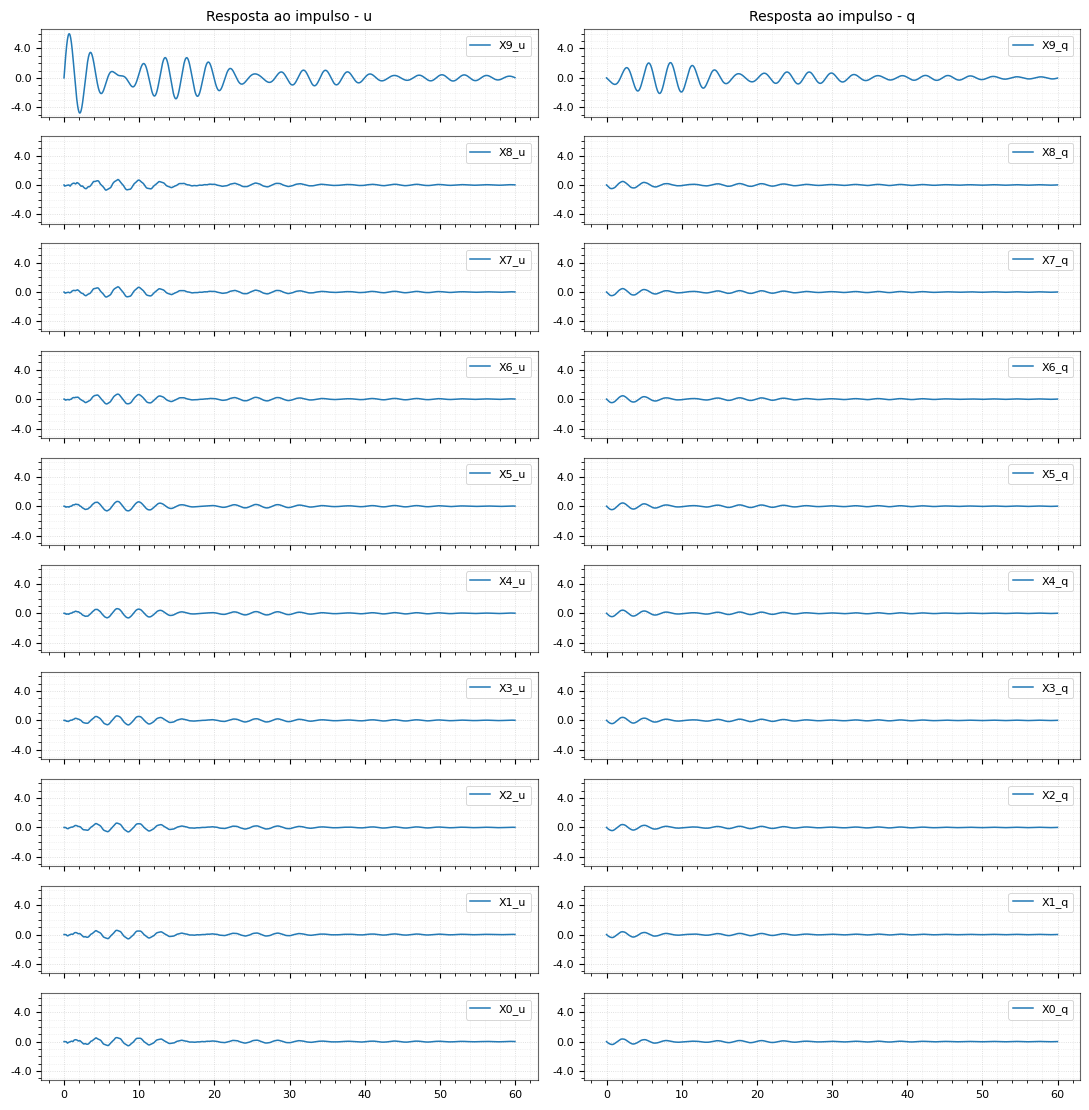

In [44]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_s_matriz[i][j], T=time_continuo)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time_continuo, y_matriz_out, "Resposta ao impulso", cols_name, plot=True)

---
### Plot - resposta ao impulso
---

c:\Users\alison.tristao\AppData\Local\anaconda3\envs\aqtech\Lib\site-packages\scipy\signal\_filter_design.py:1218: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)
C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_28152\1744747301.py:120: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


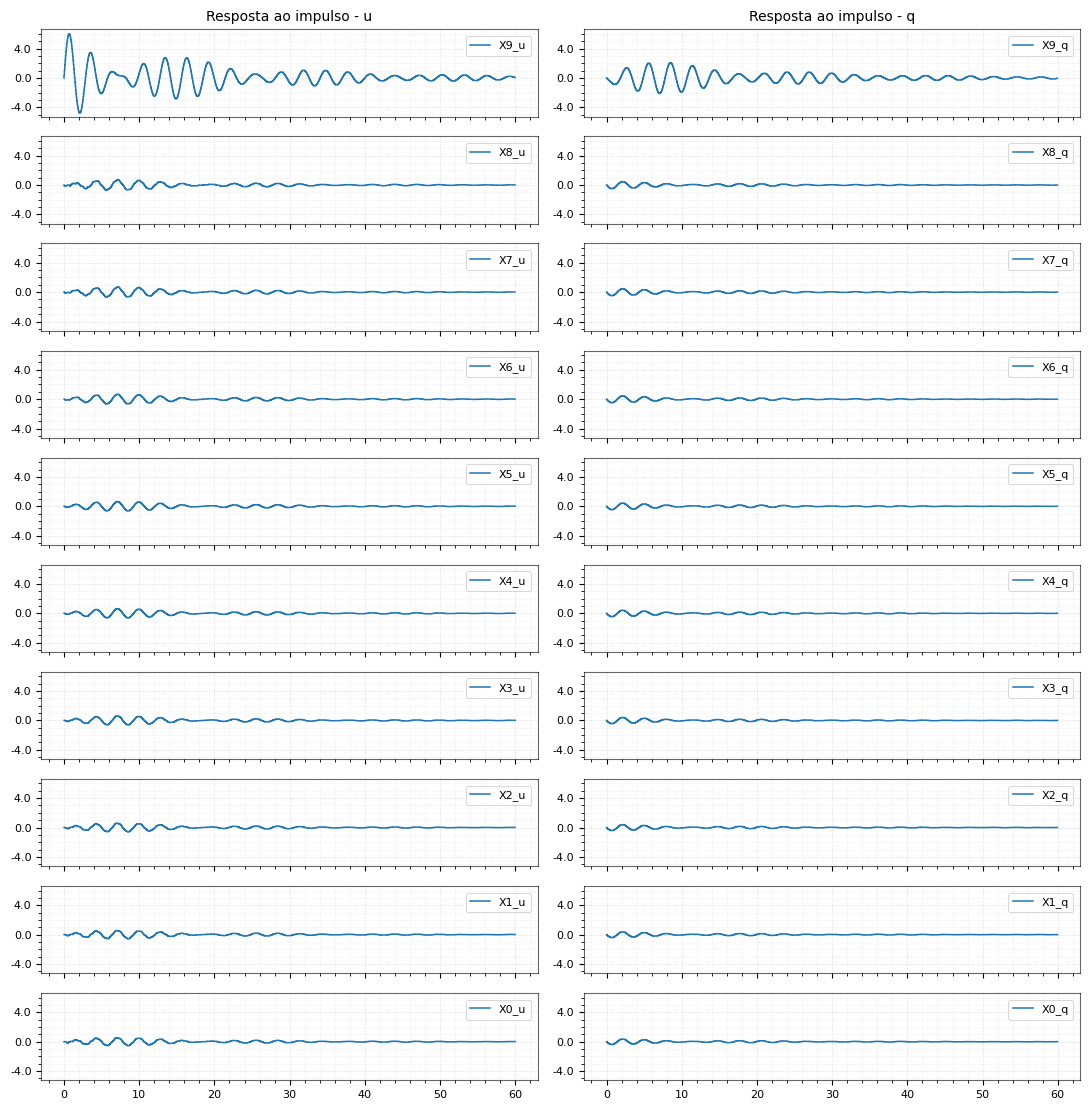

In [45]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = H_z_matriz[i][j].impulse_response(T=time)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time, y_matriz_out, "Resposta ao impulso", cols_name)

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_28152\1744747301.py:120: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


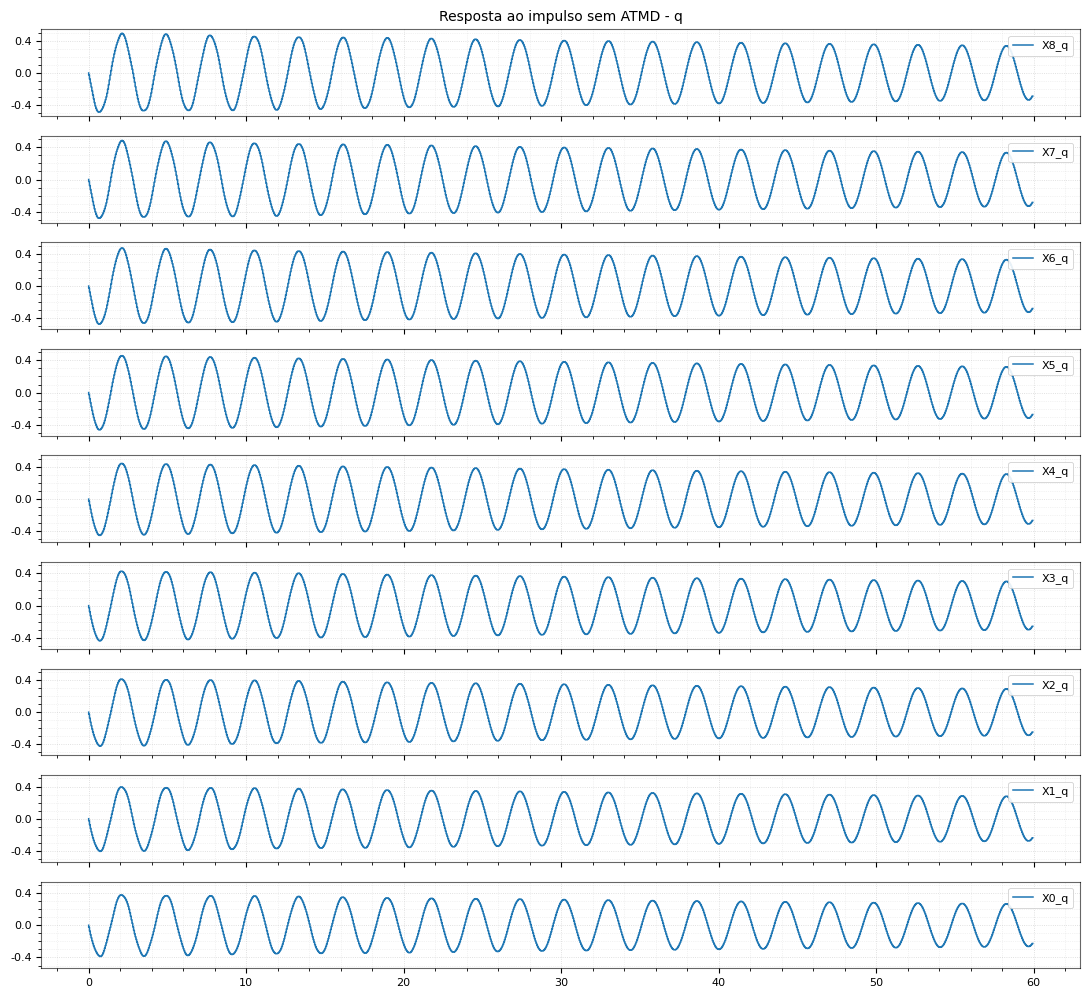

In [46]:
# plot a resposta ao impulso sem o ATMD
y_matriz_out_no_atmd = [[] for _ in range(H_Q_no_atmd.rows)]
for i in range(H_Q_no_atmd.rows):
    j = 0
    t_out, y_out = H_z_matriz_no_atmd[i][j].impulse_response(T=time)
    y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j+1]), 'C0', None]
    y_matriz_out_no_atmd[i].append(y_plot)
# plot
plot(time, y_matriz_out_no_atmd, "Resposta ao impulso sem ATMD", cols_name[1:])

---
### Predição - usando CARIMA
---

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_28152\1744747301.py:120: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


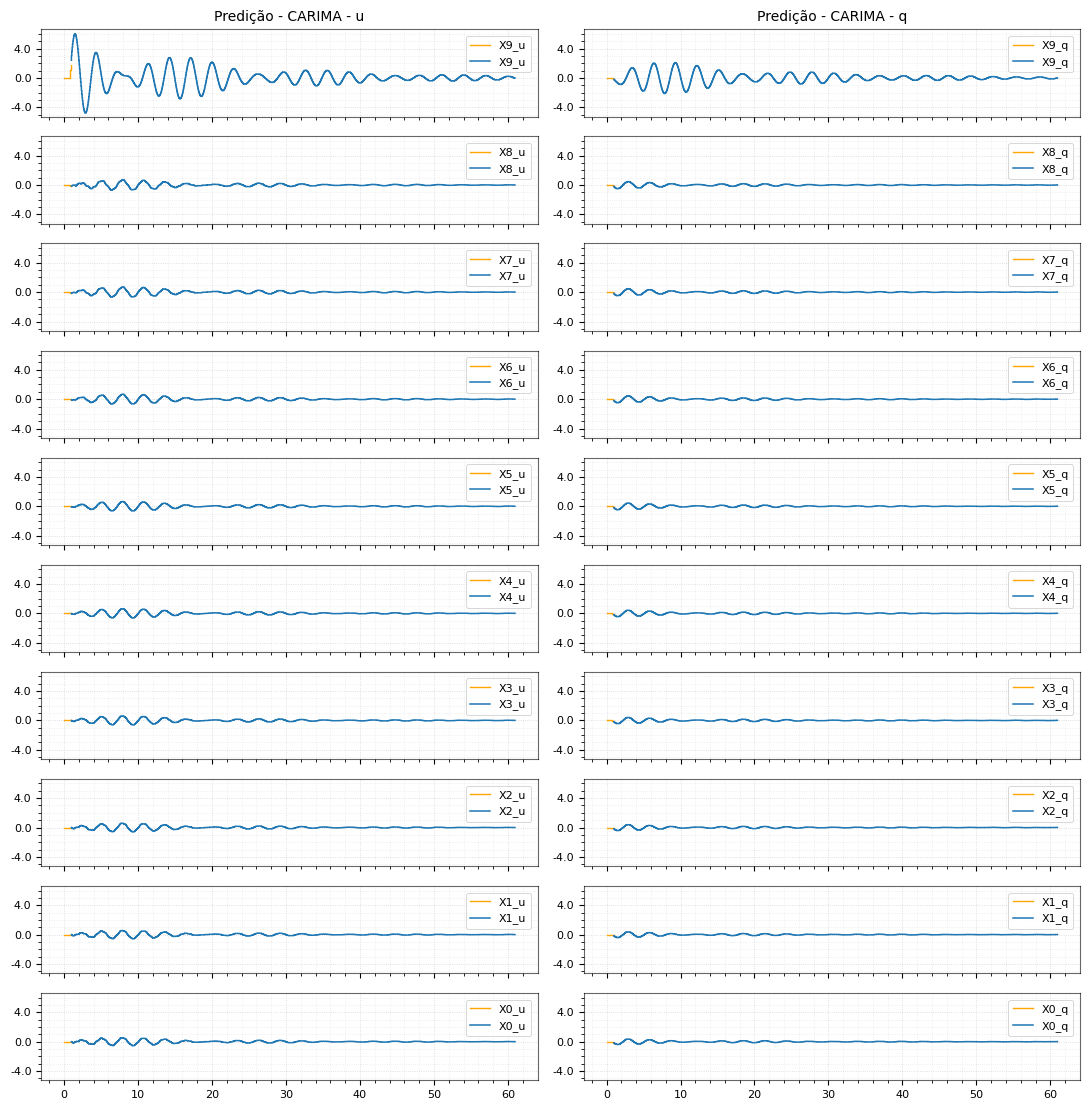

In [47]:
y_pred = [[] for _ in range(H.rows)]
y_pass = [[] for _ in range(H.rows)]
x_free = [[] for _ in range(H.rows)]

# quantidade de pontos como condição inicial
past = 3

for i in range(H.rows):
    for j in range(H.cols):
        F, G, M = generate_matrices(H_z_matriz[i][j], N_u=1, N=len(time), Ts=T)
        # matriz de past pra inicializar
        init = [0] * (F.shape[1] - past)
        perturbation = [0] * M.shape[1]
        perturbation[past-1 if past > 0 else 0] = 1 # feedfoward
        y_feedfoward = M @ perturbation
        
        # pegar a condição inicial e concate com past
        y_in =  y_matriz_out[i][j][0][1:past+1][::-1] + init

        # calcula a resposta livre
        y_out = F @ y_in
        y_out += y_feedfoward
        if j == 1:
            x_free[i].append(y_out.tolist())

        # salva pra plotar
        y_plot0 = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_plot1 = [y_in[::-1], "X{}_{}".format(i, cols_name[j]), 'orange', None]
        y_pred[i].append(y_plot0)
        y_pass[i].append(y_plot1)

# plot - menos a coluna 1 
plot(time, y_pred, "Predição - CARIMA", cols_name, time_aux=time, y_matriz_aux=y_pass)

---
### Ponderação P
---

Matriz A:
[[ 2.60663997e+00 -2.74925874e+00  2.50086177e+00 ... -1.47063839e-09
  -5.38236122e-13 -2.05391260e-15]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]]
Matriz B:
[[-9.32587341e-15]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_28152\1744747301.py:120: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


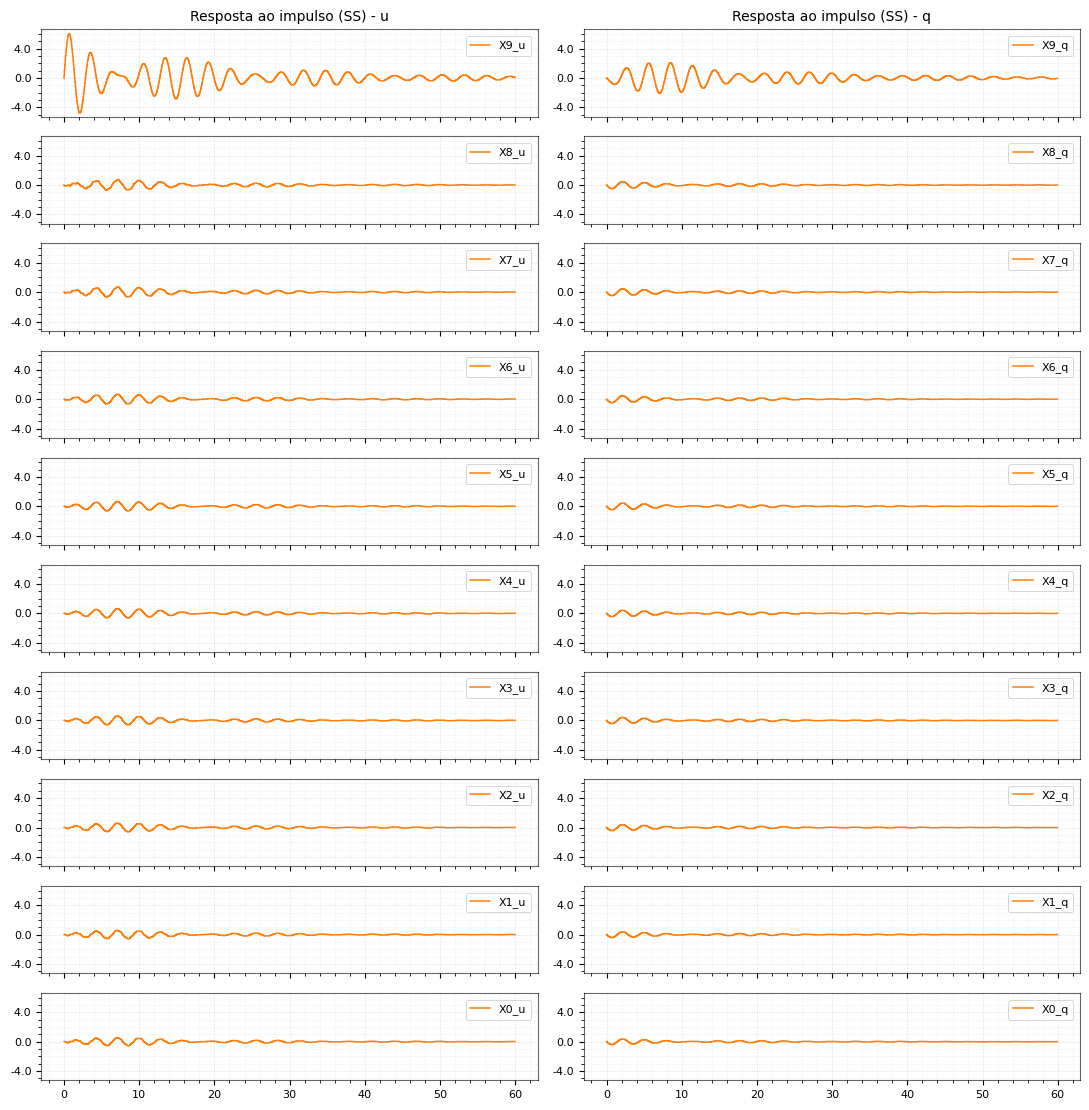

In [48]:
def ss_arx_from_ctrl_tf(G):
    """
    G: objeto control.TransferFunction (discreto, SISO)

    Constrói o espaço de estados no formato:
        x = [y(k), y(k-1), ..., y(k-ny), u(k-1), ..., u(k-nu)]'
    a partir de uma FT discreta G(z).
    """
    # extrai num, den e Ts do objeto do control
    num = np.array(G.num[0][0], dtype=float).flatten()
    den = np.array(G.den[0][0], dtype=float).flatten()
    Ts  = G.dt

    # normaliza para que den[0] = 1
    num = num / den[0]
    den = den / den[0]

    # den = [1, d1, d2, ..., d_ny]
    # modelo em diferença (convencional) costuma ser:
    # y(k+1) + d1*y(k) + ... = b0*u(k) + ...
    # e você quer: y(k+1) = a1*y(k) + ... + b0*u(k) + ...
    # logo a_i = -d_i
    a = -den[1:]         # a1..a_ny
    na = len(a)

    # coeficientes b0..b_nu
    b = num
    nu = len(b) - 1

    # tamanho do estado: y(k)...y(k-ny) e u(k-1)...u(k-nu)
    n = na + nu + 1

    A = np.zeros((n, n))

    # primeira linha: [a1 ... any | b1 ... b_nu]
    A[0, :na] = a
    if nu > 0:
        A[0, na+1 :] = b[1:]

    # shift dos y
    for i in range(1, na):
        A[i, i-1] = 1.0

    # parte dos u
    if nu > 0:
        # u(k) entra como primeiro da cadeia de atrasos de u
        A[na+1, na] = 1.0
        # shift dos atrasos de u
        for i in range(na+2, n):
            A[i, i-1] = 1.0

    # B: b0 na eq. de y(k+1) e 1 entrando na cadeia de u
    B = np.zeros((n, 1))
    B[0, 0] = b[0]
    if nu > 0:
        B[na+1, 0] = 1.0

    # saída: y(k) = primeiro estado
    C = np.zeros((1, n))
    C[0, 0] = 1.0

    D = np.zeros((1, 1))

    print("Matriz A:")
    print(A)
    print("Matriz B:")
    print(B)
    print("Matriz C:")
    print(C)
    print("Matriz D:")
    print(D)

    return ctrl.StateSpace(A, B, C, D, Ts)

H_state_space = [[] for _ in range(H.rows)]
for i in range(H.rows):
    for j in range(H.cols):
        H_state_space[i].append(ss_arx_from_ctrl_tf(H_z_matriz[i][j]))

# plot impulse response via espaço de estados
y_matriz_out_ss = [[] for _ in range(H.rows)]
for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_state_space[i][j], T=time)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C1', None]
        y_matriz_out_ss[i].append(y_plot)

# plot
plot(time, y_matriz_out_ss, "Resposta ao impulso (SS)", cols_name)


---
### simulacao bolada
---

In [49]:
N_u = 30
N_y = 30

alpha_list = 0.01
delta_arr = [0.1**i for i in range(n_node)]
delta_arr[0] = 0.1  # maior peso pra massa da nacele

R_list = np.eye(N_u) * alpha_list
Q_list = np.eye(N_y * n_node)
for i in range(n_node):
    start_idx = i * N_y
    end_idx = start_idx + N_y
    Q_list[start_idx:end_idx, start_idx:end_idx] = np.eye(N_y) * delta_arr[n_node - 1 - i]

# empilhas todas as matrizes 
G_list = []
F_list = []
M_list = []
M_q_list = []
G_q_list = []

for i in range(H.rows-1):
    F_i, G_i, M_i = generate_matrices(H_z_matriz[i][0], N_u, N_y, Ts=T)
    G_list.append(G_i)
    F_list.append(F_i)
    M_list.append(M_i)
    
    lixo1, G_q, M_q = generate_matrices(H_z_matriz[i][1], N_y, N_y, Ts=T)
    M_q_list.append(M_q)
    G_q_list.append(G_q)

# retura as ultimas N_y linhas
G_list = np.vstack(G_list)

# solution of quadratic problem
K_list = np.linalg.inv(G_list.T @ Q_list @ G_list + R_list) @ G_list.T @ Q_list


In [ ]:
def simulate_gpc(time, perturbation):
    # limites de saturação do atuador
    u_min = -10*T
    u_max =  10*T
    d_u_min = -1*T
    d_u_max = 1*T

    # limites para x 
    x_max = np.array([[7.5 for _ in range(n_node * N_y)]])
    x_min = np.array([[-7.5 for _ in range(n_node * N_y)]])

    # pontos maximos da predicao livre
    x_max_pred = np.array([[0.0 for _ in range(n_node * N_y)]])
    x_min_pred = np.array([[0.0 for _ in range(n_node * N_y)]])
    x_max_pred_feedfoward = np.array([[0.0 for _ in range(n_node * N_y)]])
    x_min_pred_feedfoward = np.array([[0.0 for _ in range(n_node * N_y)]])

    # matriz diferencial de saturação S_d u - I u_prev <= d_u_max - i [1 0 ... 0].T
    I = np.array([[1] + [0]*(N_u - 1)])
    S_d = np.zeros((N_u, N_u))
    for i in range(N_u):
        for j in range(N_u):
            if i == j:
                S_d[i, j] = 1
            elif i == j + 1:
                S_d[i, j] = -1

    # converte epsilon de tamanho 9, para um array com [e1, e1, ..., e1, e2, e2, ..., e2... e2 ... e9, e9, ..., e9]
    # O = 9 matriz identidade N_y x N_y empilhados na vertical 
    O = np.zeros((n_node * N_y, n_node))
    for i in range(n_node):
        for j in range(N_y):
            O[i * N_y + j, i] = 1

    # configuracao pro otimizador 
    precisao = 1e-6
    interacoes = 100000

    # salva os resultados da simulação para plotar  
    y_arr = [[[[], "Malha Aberta", 'C0', None],   
            [[], "GPC", 'C1', None],
            [[], "GPC - feedforward", 'C2', None]] for j in range(n_node)]
            #[[], "TMD", 'C3', None]

    # salva u_01, u_02 e q 
    u_arr = [[[[], "u", 'C1', None]],
            [[[], "u_feedforward", 'C2', None]]]
            #[[[], "q", 'C4', None]]]
            #[[[], "u_irrestrito", 'C3', None]],

    plant_arr_1 = []
    plant_arr_2 = []
    #plant_arr_3 = []
    plant_arr_ma = []

    for i in range(n_node):
        H_u = H_z_matriz[i][0]
        H_q = H_z_matriz[i][1]
        H_q_no_atmd = H_z_matriz_no_atmd[i][0]

        # controle sem feedfoward
        plant_1 = Plant(H_u, H_q)
        plant_arr_1.append(plant_1)  
        
        # controle com feedfoward
        plant_2 = Plant(H_u, H_q)
        plant_arr_2.append(plant_2)

        # controle irrestrito
        #plant_3 = Plant(H_u, H_q)
        #plant_arr_3.append(plant_3)

        # malha aberta
        plant_ma = Plant(H_q_no_atmd)
        plant_arr_ma.append(plant_ma)    

    # acao de controle
    u_opt_matr_1 = 0.0
    u_opt_matr_2 = 0.0
    #u_opt_matr_3 = 0.0

    for i in range(time):
        # array de predição
        predictions = []
        predictions_feedfoward = []
        #predictions_irrestrito = []

        # simula todos os nos
        for j in range(n_node):
            # aplica a perturbação e pega valores futuros
            q = perturbation[i-1 if i > 0 else 0]
            q_future = np.array((perturbation[i:i+N_y]))

            # roda a simulacao da planta
            y_ma = plant_arr_ma[j].step(q, 0)
            y_01 = plant_arr_1[j].step(u_opt_matr_1, q)
            y_02 = plant_arr_2[j].step(u_opt_matr_2, q)
            #y_03 = plant_arr_3[j].step(0, q)

            # pega as condicoes iniciais
            '''y_pastma = plant_arr_ma[j].y_past()
            u_pastma = plant_arr_ma[j].u_past()
            q_pastma = plant_arr_ma[j].q_past()'''
            
            y_past1 = plant_arr_1[j].y_past()
            u_past1 = plant_arr_1[j].u_past()
            #q_past1 = plant_arr_1[j].q_past()

            y_past2 = plant_arr_2[j].y_past()
            u_past2 = plant_arr_2[j].u_past()
            q_past2 = plant_arr_2[j].q_past()

            #y_past3 = plant_arr_3[j].y_past()
            #u_past3 = plant_arr_3[j].u_past()
            #q_past3 = plant_arr_3[j].q_past()

            # predição com feedfoward
            y_feedfoward = F_list[j] @ y_past2 + M_list[j] @ u_past2 + M_q_list[j] @ q_past2 + G_q_list[j] @ q_future

            # predição sem feedfoward
            pred = F_list[j] @ y_past1 + M_list[j] @ u_past1
            #pred_irrestrito = F_list[j] @ y_past3 + M_list[j] @ u_past3

            # salva a predição em um array
            predictions.append(pred)
            predictions_feedfoward.append(y_feedfoward)
            #predictions_irrestrito.append(pred_irrestrito)

            # ponto maximo da predição livre
            for k in range(N_y):
                idx = j * N_y + k
                x_max_pred[0][idx] = max(x_max_pred[0][idx], abs(pred[k]))
                x_min_pred[0][idx] = min(x_min_pred[0][idx], abs(pred[k]))
                x_max_pred_feedfoward[0][idx] = max(x_max_pred_feedfoward[0][idx], abs(y_feedfoward[k]))
                x_min_pred_feedfoward[0][idx] = min(x_min_pred_feedfoward[0][idx], abs(y_feedfoward[k]))

            # salva os resultados pra plotar
            y_arr[j][0][0].append(y_ma)
            y_arr[j][1][0].append(y_01)
            y_arr[j][2][0].append(y_02)
            #y_arr[j][3][0].append(y_03)

        # transforma em vetor para o cvxpy
        predictions = np.asarray(predictions).flatten()
        predictions_feedfoward = np.asarray(predictions_feedfoward).flatten()
        #predictions_irrestrito = np.asarray(predictions_irrestrito).flatten()

        # solucao analitica (sem saturação)
        #u_unconstrained = -K_list @ predictions_irrestrito

        # variaveis de otimizacao
        u_var_1, e1, e2 = cp.Variable(N_u), cp.Variable(n_node), cp.Variable(n_node)
        u_var_2, e3, e4 = cp.Variable(N_u), cp.Variable(n_node), cp.Variable(n_node)
        cost1 = cp.quad_form(u_var_1, R_list) + cp.quad_form(G_list @ u_var_1 + predictions, Q_list) + cp.quad_form(e1, 1e6 * np.eye(n_node)) + cp.quad_form(e2, 1e6 * np.eye(n_node))
        cost2 = cp.quad_form(u_var_2, R_list) + cp.quad_form(G_list @ u_var_2 + predictions_feedfoward, Q_list) + cp.quad_form(e3, 1e6 * np.eye(n_node)) + cp.quad_form(e4, 1e6 * np.eye(n_node))

        # função objetivo
        objective1 = cp.Minimize(cost1)
        objective2 = cp.Minimize(cost2)

        # restrições de saturação
        constraints1 = [
            u_var_1 <= u_max,
            u_var_1 >= u_min,
            S_d @ u_var_1 - I * u_var_1[0] <= d_u_max,
            S_d @ u_var_1 - I * u_var_1[0] >= d_u_min,
            G_list @ u_var_1 + predictions <= x_max_pred + O @ e1,
            G_list @ u_var_1 + predictions >= x_min_pred - O @ e2
        ]
        constraints2 = [
            u_var_2 <= u_max,
            u_var_2 >= u_min,
            S_d @ u_var_2 - I * u_var_2[0] <= d_u_max,
            S_d @ u_var_2 - I * u_var_2[0] >= d_u_min,
            G_list @ u_var_2 + predictions_feedfoward <= x_max_pred_feedfoward + O @ e3,
            G_list @ u_var_2 + predictions_feedfoward >= x_min_pred_feedfoward - O @ e4,
        ]

        # problema para minimização
        prob1 = cp.Problem(objective1, constraints1)
        prob2 = cp.Problem(objective2, constraints2)

        prob1.solve(
            solver=cp.OSQP,
            eps_abs=precisao,
            eps_rel=precisao,
            max_iter=interacoes,
            polish=True,
            verbose=False
        )
        prob2.solve(
            solver=cp.OSQP,
            eps_abs=precisao,
            eps_rel=precisao,
            max_iter=interacoes,
            polish=True,
            verbose=False
        )

        # pega a primeira ação de controle
        u_opt_matr_1 = u_var_1.value[0]
        u_opt_matr_2 = u_var_2.value[0]
        #u_opt_matr_3 = u_unconstrained[0]

        # saturação
        u_opt_matr_1 = max(min(u_opt_matr_1, u_max), u_min)
        u_opt_matr_2 = max(min(u_opt_matr_2, u_max), u_min)
        #u_opt_matr_3 = max(min(u_opt_matr_3, u_max), u_min)

        # salva a ação de controle para plotar
        u_arr[0][0][0].append(u_opt_matr_1)
        u_arr[1][0][0].append(u_opt_matr_2)
        #u_arr[2][0][0].append(u_opt_matr_3)
        #u_arr[2][0][0].append(q)

    return y_arr, u_arr

# perturbacao senoidal
perturbation = [0.0] * (len(time)+N_y)
perturbation[N_y + N_y] = 1/T # impulso em t=1s '''

# senoide para valores maiores q 5s
'''for i in range(len(perturbation)):
    t = i * T
    perturbation[i] = 1/T * np.sin(5.0 * t)'''

y_arr, u_arr = simulate_gpc(len(time), perturbation)

c:\Users\alison.tristao\AppData\Local\anaconda3\envs\aqtech\Lib\site-packages\cvxpy\reductions\solvers\solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
c:\Users\alison.tristao\AppData\Local\anaconda3\envs\aqtech\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_28152\2803524978.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


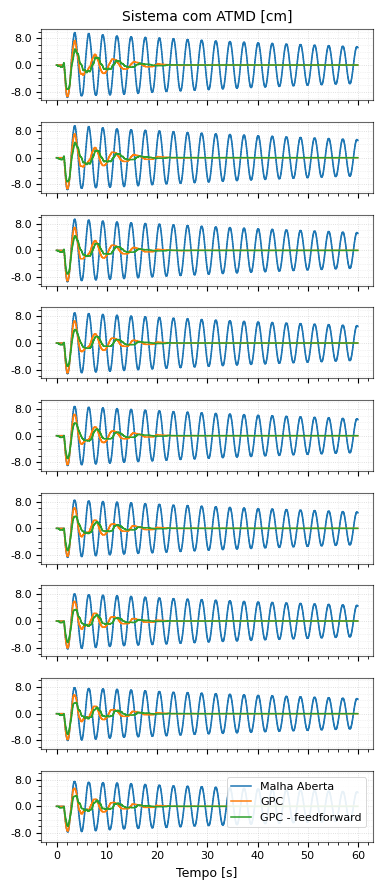

In [ ]:
plot_1_column(time, y_arr, title="Sistema com ATMD [cm]", x_label="Tempo [s]")

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_28152\2803524978.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


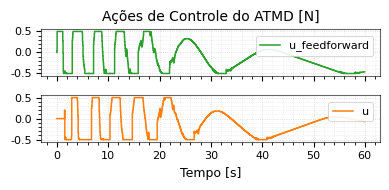

In [ ]:
plot_1_column(time, u_arr, title="Ações de Controle do ATMD [N]", x_label="Tempo [s]", legend=True)

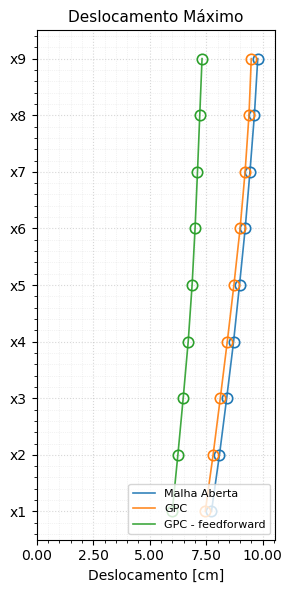

In [ ]:
plot_ladder_uq(y_arr, x_label="Deslocamento [cm]", cols_name=["Malha Aberta", "GPC", "GPC - feedforward", "TMD"], title="Deslocamento Máximo")
# anima apenas 1/3 do tempo pra ficar mais rápido
#plot_ladder_uq_gif(time, y_arr, x_label="Deslocamento [mm]", cols_name=["Malha Aberta", "GPC", "GPC - feedforward"], title="Deslocamento no Tempo", Ts=100)

---
### Grafico de bode
---

In [ ]:
# eixo x do bode 
'''freq_inicial = 1    # 0 Hz
freq_final = 10  # 100 Hz
freqs_out = np.logspace(np.log10(freq_inicial + 1e-3), np.log10(freq_final), num=30) - 1e-3
print(freqs_out)

time_simulation = 30 # segundos
steps = int(time_simulation//T)

# salva as amplitudes de saída
amps_out = [[[[], "Malha Aberta", 'C0', None], 
            [[], "GPC", 'C1', None],
            [[], "GPC - feedforward", 'C2', None]] for j in range(n_node)]

for w in freqs_out:
    perturbation = [0.0] * (steps + N_y)
    for i in range(len(perturbation)):
        t = i * T
        perturbation[i] = 1 * np.sin(w * t)

    y_result, u_result = simulate_gpc(steps, perturbation)

    for j in range(n_node):
        xi = np.array(y_result[j][1][0])  # GPC
        xf = np.array(y_result[j][2][0])  # GPC feedforward
        xm = np.array(y_result[j][0][0])  # Malha Aberta

        amps_out[j][0][0].append((np.max(xm[int(steps//2):]) - np.min(xm[int(steps//2):]))/2)
        amps_out[j][1][0].append((np.max(xi[int(steps//2):]) - np.min(xi[int(steps//2):]))/2)
        amps_out[j][2][0].append((np.max(xf[int(steps//2):]) - np.min(xf[int(steps//2):]))/2)'''

'freq_inicial = 1    # 0 Hz\nfreq_final = 10  # 100 Hz\nfreqs_out = np.logspace(np.log10(freq_inicial + 1e-3), np.log10(freq_final), num=30) - 1e-3\nprint(freqs_out)\n\ntime_simulation = 30 # segundos\nsteps = int(time_simulation//T)\n\n# salva as amplitudes de saída\namps_out = [[[[], "Malha Aberta", \'C0\', None], \n            [[], "GPC", \'C1\', None],\n            [[], "GPC - feedforward", \'C2\', None]] for j in range(n_node)]\n\nfor w in freqs_out:\n    perturbation = [0.0] * (steps + N_y)\n    for i in range(len(perturbation)):\n        t = i * T\n        perturbation[i] = 1 * np.sin(w * t)\n\n    y_result, u_result = simulate_gpc(steps, perturbation)\n\n    for j in range(n_node):\n        xi = np.array(y_result[j][1][0])  # GPC\n        xf = np.array(y_result[j][2][0])  # GPC feedforward\n        xm = np.array(y_result[j][0][0])  # Malha Aberta\n\n        amps_out[j][0][0].append((np.max(xm[int(steps//2):]) - np.min(xm[int(steps//2):]))/2)\n        amps_out[j][1][0].append((n

In [ ]:
amps_out = [[[[], "Malha Aberta", 'C0', None], 
            [[], "GPC", 'C1', None],
            [[], "GPC - feedforward", 'C2', None]] for j in range(n_node)]
freqs_out = []

# final 
final = 1 # 1Hz

def fft(x, T):
    """
    x  : sinal no tempo (array 1D)
    fs : frequência de amostragem [Hz]
    
    Retorna:
        freqs : vetor de frequências [Hz]
        X     : FFT complexa
        mag   : módulo da FFT (amplitude)
    """
    x = np.asarray(x)
    size = len(x)               
    X = np.fft.fft(x)         
    freqs = np.fft.fftfreq(size, d=T) 
    mag = np.abs(X)           
    #mag = 20 * np.log10(mag + 1e-20) # em dB

    return freqs, X, mag

for j in range(n_node):
    for k in range(len(amps_out[j])):
        xi = np.array(y_arr[j][k][0])
        freqs, X, mag = fft(xi, T)

        # adiciona o array no amps_out
        metade_positiva = int(len(freqs)//2)

        # valores maiores q 0.1
        inicio_idx = 0
        for idx in range(metade_positiva):
            if freqs[idx] >= 0.1:
                inicio_idx = idx
                break

        amps_out[j][k][0] = mag[inicio_idx:metade_positiva]  # só metade positiva

        # salva as freqs 
        freqs_out = freqs[inicio_idx:metade_positiva]

        # pega de zero até final
        final_idx = 0
        for idx in range(len(freqs_out)):
            if freqs_out[idx] >= final:
                final_idx = idx
                break
        freqs_out = freqs_out[:final_idx]
        amps_out[j][k][0] = amps_out[j][k][0][:final_idx]

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_28152\1721437467.py:114: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


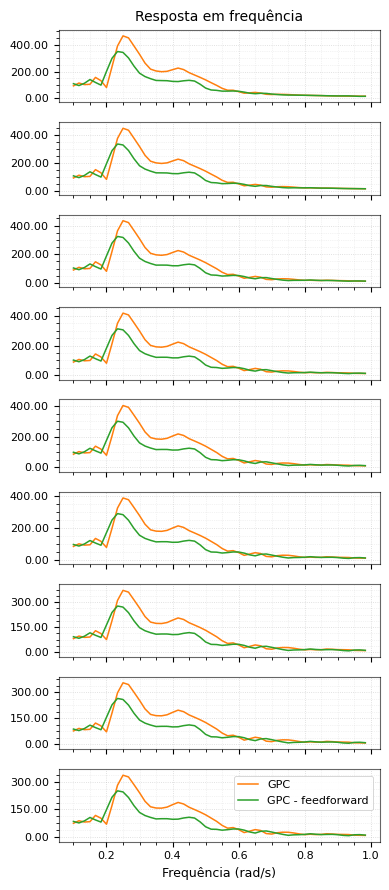

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_28152\1721437467.py:114: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


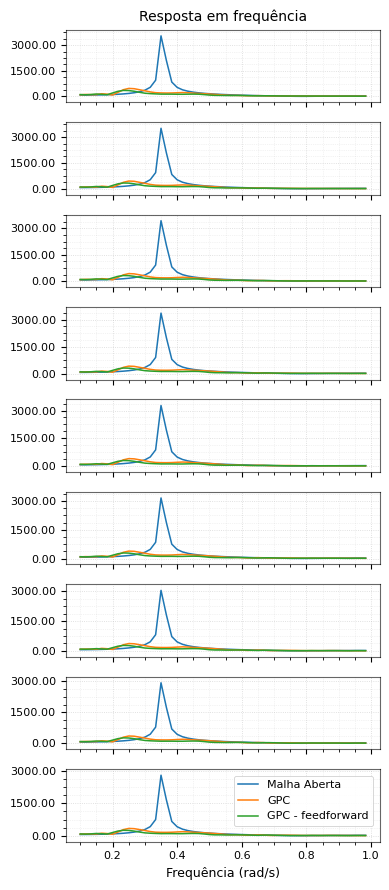

In [ ]:
# 5) plota
plot_bode_1_column(
    freqs_out,
    # apenas as duas ultimas colunas (GPC e GPC feedforward)
    [amps_out[j][1:] for j in range(len(amps_out))],
    x_label="Frequência (rad/s)",
    title="Resposta em frequência"
)

plot_bode_1_column(
    freqs_out,
    amps_out,
    x_label="Frequência (rad/s)",
    title="Resposta em frequência"
)

